In [161]:
import bart
import cfl
import matplotlib.pyplot as plt
import numpy as np
import pdb

In [162]:
# simulate noiseless phantom data
nkyz = 256
nc = 8
ksp_ful_nonoise = bart.bart(1, 'phantom -x {} -k -s {}'.format(nkyz, nc))
ksp_ful_nonoise.shape

(256, 256, 1, 8)

In [163]:
# add noise
noi_var = 3000
seed = np.random.randint(0, 2**63-1)
ksp_ful = bart.bart(1, 'noise -n {} -s {}'.format(noi_var, seed), ksp_ful_nonoise)
ksp_ful.shape

(256, 256, 1, 8)

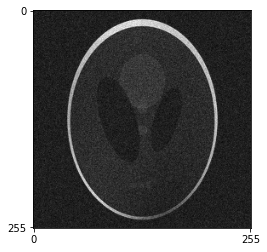

In [164]:
# root-sum-of-squares reconstruction from fully-sampled data
im_ful_coil = bart.bart(1, 'fft -i -u $(bart bitmask 0 1)', ksp_ful)
im_ful_rss = bart.bart(1, 'rss $(bart bitmask 3)', im_ful_coil)

_, ax = plt.subplots()
ax.set_xticks([0, nkyz-1])
ax.set_yticks([0, nkyz-1])
ax.imshow(abs(im_ful_rss), cmap='gray')

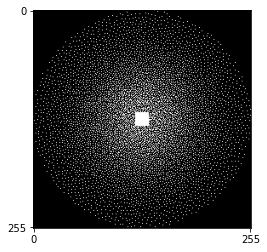

In [165]:
# construct poisson-disk undersampling mask (todo: samples shifted onto cartesian grid?)
acc_y = 1.5
acc_z = 1.5
calib_dim = 16
mask_args = (nkyz, nkyz, acc_y, acc_z, calib_dim)
mask = bart.bart(1, 'poisson -Y {} -Z {} -y {} -z {} -C {} -v -e'.format(*mask_args))
mask = mask.reshape(nkyz, nkyz)

_, ax = plt.subplots()
ax.set_xticks([0, nkyz-1])
ax.set_yticks([0, nkyz-1])
ax.imshow(abs(mask), cmap='gray')

In [166]:
# apply mask to fully-sampled data
ksp = bart.bart(1, 'fmac', ksp_ful, mask) # todo: note broadcasting

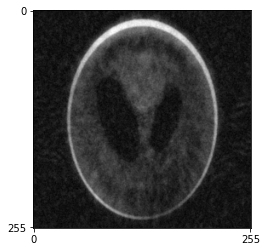

In [167]:
# check effect of masking via simple zero-filled reconstruction
im_coil = bart.bart(1, 'fft -i -u $(bart bitmask 0 1)', ksp)
im_rss = bart.bart(1, 'rss $(bart bitmask 3)', im_coil)

_, ax = plt.subplots()
ax.set_xticks([0, nkyz-1])
ax.set_yticks([0, nkyz-1])
ax.imshow(abs(im_rss), cmap='gray')

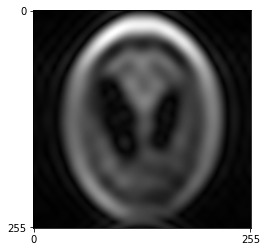

In [168]:
# simulate low-resolution data for coil sensitivity estimation
ksp_smap_nonoise = bart.bart(1, 'phantom -x {} -k -s {}'.format(calib_dim, nc))
seed_smap = np.random.randint(0, 2**63-1)
pad = int((nkyz-calib_dim)/2)
ksp_smap = np.pad(bart.bart(1, 'noise -n {} -s {}'.format(noi_var, seed_smap),
                            ksp_smap_nonoise),
                  ((pad,), (pad,), (0,), (0,)))

im_coil_smap = bart.bart(1, 'fft -i -u $(bart bitmask 0 1 2)', ksp_smap)
im_rss_smap = bart.bart(1, 'rss $(bart bitmask 3)', im_coil_smap)

_, ax = plt.subplots()
ax.set_xticks([0, nkyz-1])
ax.set_yticks([0, nkyz-1])
ax.imshow(abs(im_rss_smap), cmap='gray')

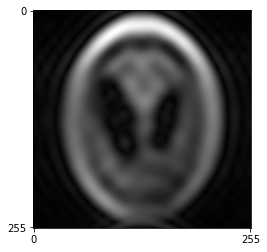

In [204]:
# compress coil sensitivity data to ncc virtual coils 
ncc = 5
ksp_smap_cc = bart.bart(1, 'cc -p {}'.format(ncc), ksp_smap)

im_coil_smap = bart.bart(1, 'fft -i -u $(bart bitmask 0 1 2)', ksp_smap_cc)
im_rss_smap = bart.bart(1, 'rss $(bart bitmask 3)', im_coil_smap)

_, ax = plt.subplots()
ax.set_xticks([0, nkyz-1])
ax.set_yticks([0, nkyz-1])
ax.imshow(abs(im_rss_smap), cmap='gray')

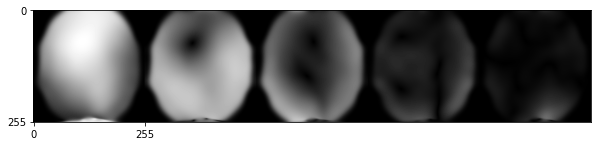

In [205]:
# estimate coil sensitivities via ESPIRiT
smap = bart.bart(1, 'ecalib -m 1 -S', ksp_smap_cc) # -m 1 skips (eig?) maps on 4th dim
_, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([0, nkyz-1])
ax.set_yticks([0, nkyz-1])
ax.imshow(np.concatenate([abs(smap[:,:,0,i]) for i in range(ncc)], 1), cmap='gray')